In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
from sklearn.model_selection import train_test_split
import gensim
import gc
from sklearn.linear_model import LogisticRegression

In [2]:
class Prepare_machine:
    
    def __init__(self, data):
        self.data = data
        
    def remove_pattern(self, to_replace=None, to_regular=None):
        if to_replace == None and to_regular == None:
            raise Exeption("Empty argumets!")
        if to_replace is not None:
            def del_links(s):
                return s.replace(to_replace,'')
            self.data = self.data.apply(del_links)
        if to_regular is not None:
            def del_with_regular(s):
                return re.sub(to_regular, '', s, flags=re.MULTILINE)
            self.data = self.data.apply(del_with_regular)
        return self.data
    
    def remove_punctuation(self):
        def del_punctuation(s):
            return ''.join([l for l in s if l not in string.punctuation])
        self.data = self.data.apply(del_punctuation)
        return self.data
    
    def remove_numbers(self):
        def del_num(s):
            return ''.join([i for i in s if not i.isdigit()])
        self.data = self.data.apply(del_num)
        return self.data
    
    def tokenize(self, reg):
        self.data = self.data.apply(lambda s: s.lower())
        tokenizer = nltk.tokenize.RegexpTokenizer(reg)
        self.data = self.data.apply(lambda s: tokenizer.tokenize(s))
        return self.data
    
    def remove_stop_words(self):
        def del_stop_words(s):
            return [w for w in s if w not in nltk.corpus.stopwords.words('english')]
        self.data = self.data.apply(del_stop_words)
        return self.data
    
    def lemmatizing(self):
        lemmatizer = nltk.stem.WordNetLemmatizer()
        def lemm(s):
            return [lemmatizer.lemmatize(w) for w in s]
        self.data = self.data.apply(lemm)
        return self.data
        
    def stemming(self):
        stemmer = nltk.stem.porter.PorterStemmer()
        def stemm(s):
            return [stemmer.stem(w) for w in s]
        self.data = self.data.apply(stemm)
        return self.data
    
    def default_pipeline(self, to_replace = None, to_regular = None,
                        token_reg = None, short_words = 'lemm'):
        if short_words is not 'lemm' and short_words is not 'stemm':
            raise Exeption(f'Unknown tool: {short_words}')
        print('Removing patterns...')
        self.remove_pattern(to_replace=to_replace, to_regular=to_regular)
        print('Removing punctuation...')
        self.remove_punctuation()
        print('Removing numbers...')
        self.remove_numbers()
        print('Tokenizing...')
        self.tokenize(reg = token_reg)
        print('Removing stop words...')
        self.remove_stop_words()
        if short_words == 'stemm':
            print('Stemming...')
            self.stemming()
        else:
            print('Lemmatizing...')
            self.lemmatizing()
        print('Done!')
        return self.data
    
    def save_csv(self, name = 'data.csv'):
        self.data.to_csv(name)

In [3]:
data = pd.read_csv('./datasets/training.1600000.processed.noemoticon.csv', 
                   encoding='ISO-8859-1',
                   names=['label','id', 'date','query', 'name','tweet'])

prep = Prepare_machine(data=data['tweet'])
prep.default_pipeline(to_replace=None,
                      to_regular=r"http\S+",
                     token_reg=r'\w+',
                     short_words = 'lemm');

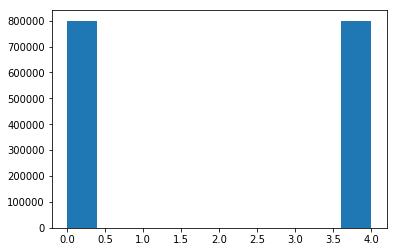

In [5]:
labels = data['label']
plt.hist(labels);

In [24]:
data['tweet'] = prep.data
data.head()

,label,id,date,query,name,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[switchfoot, awww, thats, bummer, shoulda, got..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[upset, cant, update, facebook, texting, might..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[kenichan, dived, many, time, ball, managed, s..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[nationwideclass, behaving, im, mad, cant, see]"


In [26]:
prepared_data = data['tweet']
w2v = gensim.models.word2vec.Word2Vec(size=200,
                                        window=7,
                                        min_count=15,
                                        workers=4)
w2v.build_vocab(prepared_data)

In [27]:
words = w2v.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 29152


In [29]:
%%time
w2v.train(prepared_data,total_examples=len(prepared_data), epochs=40)

CPU times: user 48min 19s, sys: 20.1 s, total: 48min 39s
Wall time: 17min 39s


(406027739, 490890320)

In [34]:
w2v.most_similar('rofl')

/home/hacket/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lmfao', 0.49852320551872253),
 ('lmao', 0.45016756653785706),
 ('xd', 0.4494699239730835),
 ('ahaha', 0.44786402583122253),
 ('haha', 0.4337320029735565),
 ('lol', 0.411421000957489),
 ('sowy', 0.40290015935897827),
 ('himynameisrose', 0.3966992497444153),
 ('joke', 0.3944868743419647),
 ('miriamcheah', 0.3920188546180725)]

In [12]:
index2word_set = set(w2v.wv.index2word)

def featureVecMethod(words, model, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    for word in  words.split():
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    featureVec = np.divide(featureVec, nwords)
    return featureVec
featureVecMethod(model=w2v,words=prep_data['tweet'][0], num_features=200)

/home/hacket/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


array([-2.92865629e-03, -7.61170268e-01, -2.22437888e-01,  1.57461241e-01,
        4.99672592e-01,  2.44937494e-01,  4.87527192e-01, -3.05193841e-01,
        5.91548979e-01,  1.04022168e-01, -1.78655639e-01, -3.79262298e-01,
        4.85999361e-02,  7.48429820e-02,  1.26162227e-02, -1.16390303e-01,
        9.96585637e-02, -3.35234627e-02,  2.35826135e-01, -1.63960248e-01,
        2.65031010e-01, -4.82740819e-01,  5.71364880e-01, -4.68691200e-01,
       -2.89965272e-01,  1.69161670e-02, -5.22059083e-01, -4.40463051e-02,
       -4.85579193e-01, -7.62962401e-02, -1.14583552e-01,  6.93104491e-02,
        5.06011955e-02, -3.88383090e-01,  2.23617554e-01, -4.83963005e-02,
        1.87157840e-01,  7.30818487e-04,  7.26907670e-01,  2.43645042e-01,
        1.67071998e-01,  4.25127894e-01,  3.12987953e-01,  5.63850522e-01,
       -2.57451594e-01,  4.06299122e-02, -2.70173848e-01, -2.37431407e-01,
       -2.15783879e-01, -2.04685569e-01, -1.64656371e-01, -6.18893504e-01,
       -2.75088429e-01,  

In [14]:
%time

encoded_twets = []
for tweet in prep_data['tweet']:
    encoded_twets.append(featureVecMethod(words=tweet, model=w2v, num_features=200))

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 14.5 µs


/home/hacket/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/hacket/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
encoded_twets = np.array(encoded_twets).reshape([-1,200])

In [14]:
nan_rows = np.unique(np.argwhere(np.isnan(encoded_tweets))[:,0])
labels = np.delete(labels.values,nan_rows)
encoded_tweets = np.delete(encoded_tweets,nan_rows, axis=0)

In [18]:
labels[np.where(labels==4)] = 1
X_train, X_test, y_train, y_test = train_test_split(encoded_tweets,labels, test_size=0.3)

In [ ]:
# my laptop RAM is not enough, so i trained model in google colab
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
